In [1]:
class bcolors:
    OK = '\033[92m' #GREEN
    WARNING = '\033[93m' #YELLOW
    FAIL = '\033[91m' #RED
    RESET = '\033[0m' #RESET COLOR

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models
import matplotlib.pyplot as plt
import time
import os
import copy

import albumentations as A
from albumentations.pytorch import ToTensorV2

from math import ceil

import sys
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter

import pandas as pd
import seaborn as sns

print(f'{bcolors.OK}Enviroment setup complete!{bcolors.RESET}')

Enviroment setup complete!


In [3]:
writer = SummaryWriter('runs/Resnet_From_Scratch')

In [4]:
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, classification_report
print(f'{bcolors.OK}Sk Learn setup complete!{bcolors.RESET}')

Sk Learn setup complete!


In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'{bcolors.OK}{device}{bcolors.RESET}')

cuda:0


In [6]:
hyper_parameter = {
    "learning_rate": 0.001,
    "batch_size": 2,
    "num_workers": 2,
    "no_epochs": 10,
    "image_size": 256, 
    "in_channels": 3, 
    "num_classes": 8,
}

In [7]:
class Transforms:
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, img, *args, **kwargs):
        return self.transforms(image=np.array(img))['image']

In [8]:
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]
hyper_parameter['image_size']=256

data_transforms = {
    'train': A.Compose([A.Resize(hyper_parameter['image_size'] , hyper_parameter['image_size']), A.Normalize(mean, std), ToTensorV2()]),
    'test': A.Compose([A.Resize(hyper_parameter['image_size'] , hyper_parameter['image_size']), A.Normalize(mean, std), ToTensorV2()])
}

In [9]:
data_dir = 'D:\sl\images'
sets = ['train', 'test']

In [10]:
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), transform =Transforms(transforms=data_transforms[x])) for x in ['train', 'test']}

In [11]:
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=hyper_parameter['batch_size'], shuffle=True) for x in ['train', 'test']}

In [12]:
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('train: {} test: {}'.format(dataset_sizes['train'], dataset_sizes['test']))
print(class_names)

train: 20265 test: 5066
['AK', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'SCC', 'VASC']


In [13]:
def imshow(inp, title):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.title(title)
    plt.show()

torch.Size([2, 3, 256, 256])


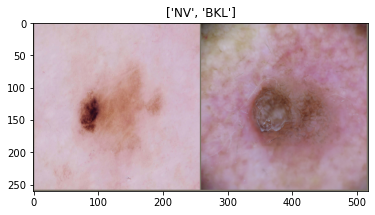

In [14]:
inputs, classes = next(iter(dataloaders['test']))
# print(inputs)
# print(classes)
print(inputs.size())
img_grid = torchvision.utils.make_grid(inputs)
writer.add_image('Cancer images', img_grid)
imshow(img_grid, title=[class_names[x] for x in classes])                    
writer.close()

In [15]:
def train_model(model, cirterion, optimizer, scheduler, num_epochs = 1):
  since = time.time()

  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0.0
  # best_sk_acc = 0.0
  best_f1_scr = 0.0

  for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch + 1, num_epochs))
    print('-' * 15)

    for phase in ['train', 'test']:
      if phase =='train':
        model.train()
      else:
        model.eval()
      
      running_loss = 0.0
      running_corrects = 0.0

      real_targets = []
      predicted_targets = []

      # Iterate over data.
      for inputs, labels in dataloaders[phase]:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # forward
        # track history only if train
        with torch.set_grad_enabled(phase == 'train'):
          outputs = model(inputs)
          _, preds = torch.max(outputs, 1)
          

          real_targets.extend(labels.detach().cpu().numpy())
          predicted_targets.extend(preds.detach().cpu().numpy())

          loss = cirterion(outputs, labels)

          #backward + optimize only if in train
          if phase == 'train':
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
      
      if phase == 'train':
        scheduler.step()

      # sk_epoch_acc = accuracy_score(predicted_targets, real_targets)
      sk_f1 = f1_score(predicted_targets, real_targets, average='micro')

      epoch_loss = running_loss / dataset_sizes[phase]
      epoch_acc = running_corrects / dataset_sizes[phase]

      # printing epoch resutlts
      print(f'{phase} Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}')
      print(f'{phase} F1 Score: {sk_f1:.4f}')
      epoch_time = time.time() - since
      print(f'Epoch time: {epoch_time // 60:.0f}m {epoch_time %  60:.0f}s')

      if phase == 'test' and epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model_wts = copy.deepcopy(model.state_dict())

      # if phase == 'test' and sk_epoch_acc > best_sk_acc:
      #   best_sk_acc = sk_epoch_acc
      #   best_model_wts = copy.deepcopy(model.state_dict())
      
      
      if phase == 'test' and sk_f1 > best_f1_scr:
        best_f1_scr = sk_f1

    print()
  
  # printing time require to train model
  time_elapsed = time.time() - since
  print(f'Training complete in {time_elapsed // 60:.0f}m { time_elapsed % 60:.0f}s')

  t = time.localtime()
  current_time = time.strftime("%H:%M", t)
  print(f'Trainig completed at {current_time}')
  print(f'Best val Acc: {best_acc:4f}')
  # print(f'Best sk Acc: {best_sk_acc:4f}')
  print(f'Best sk F1 : {best_f1_scr:4f}')

  # load best model weights
  model.load_state_dict(best_model_wts)
  return model

In [16]:
class block(nn.Module):
    def __init__(
        self, in_channels, intermediate_channels, identity_downsample=None, stride=1
    ):
        super(block, self).__init__()
        self.expansion = 4
        self.conv1 = nn.Conv2d(
            in_channels, intermediate_channels, kernel_size=1, stride=1, padding=0, bias=False
        )
        self.bn1 = nn.BatchNorm2d(intermediate_channels)
        self.conv2 = nn.Conv2d(
            intermediate_channels,
            intermediate_channels,
            kernel_size=3,
            stride=stride,
            padding=1,
            bias=False
        )
        self.bn2 = nn.BatchNorm2d(intermediate_channels)
        self.conv3 = nn.Conv2d(
            intermediate_channels,
            intermediate_channels * self.expansion,
            kernel_size=1,
            stride=1,
            padding=0,
            bias=False
        )
        self.bn3 = nn.BatchNorm2d(intermediate_channels * self.expansion)
        self.relu = nn.ReLU()
        self.identity_downsample = identity_downsample
        self.stride = stride

    def forward(self, x):
        identity = x.clone()

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.bn3(x)

        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)

        x += identity
        x = self.relu(x)
        return x


In [17]:
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
    
    def forward(self, x):
        return x

In [18]:
class ResNet(nn.Module):
    def __init__(self, block, layers, image_channels, num_classes):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(image_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Essentially the entire ResNet architecture are in these 4 lines below
        self.layer1 = self._make_layer(
            block, layers[0], intermediate_channels=64, stride=1
        )
        self.layer2 = self._make_layer(
            block, layers[1], intermediate_channels=128, stride=2
        )
        self.layer3 = self._make_layer(
            block, layers[2], intermediate_channels=256, stride=2
        )
        self.layer4 = self._make_layer(
            block, layers[3], intermediate_channels=512, stride=2
        )

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * 4, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)

        return x

    def _make_layer(self, block, num_residual_blocks, intermediate_channels, stride):
        identity_downsample = None
        layers = []

        # Either if we half the input space for ex, 56x56 -> 28x28 (stride=2), or channels changes
        # we need to adapt the Identity (skip connection) so it will be able to be added
        # to the layer that's ahead
        if stride != 1 or self.in_channels != intermediate_channels * 4:
            identity_downsample = nn.Sequential(
                nn.Conv2d(
                    self.in_channels,
                    intermediate_channels * 4,
                    kernel_size=1,
                    stride=stride,
                    bias=False
                ),
                nn.BatchNorm2d(intermediate_channels * 4),
            )

        layers.append(
            block(self.in_channels, intermediate_channels, identity_downsample, stride)
        )

        # The expansion size is always 4 for ResNet 50,101,152
        self.in_channels = intermediate_channels * 4

        # For example for first resnet layer: 256 will be mapped to 64 as intermediate layer,
        # then finally back to 256. Hence no identity downsample is needed, since stride = 1,
        # and also same amount of channels.
        for i in range(num_residual_blocks - 1):
            layers.append(block(self.in_channels, intermediate_channels))

        return nn.Sequential(*layers)


def ResNet50(img_channel=3, num_classes=1000):
    return ResNet(block, [3, 4, 6, 3], img_channel, num_classes)


def ResNet101(img_channel=3, num_classes=1000):
    return ResNet(block, [3, 4, 23, 3], img_channel, num_classes)


def ResNet152(img_channel=3, num_classes=1000):
    return ResNet(block, [3, 8, 36, 3], img_channel, num_classes)


In [19]:
def test():
    net = ResNet152(img_channel=3, num_classes=1000)
    y = net(torch.randn(4, 3, 224, 224)).to("cuda")
    print(y.size())

test()

torch.Size([4, 1000])


In [20]:
model = ResNet152(img_channel=3, num_classes=1000)
print(model.parameters)

<bound method Module.parameters of ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): block(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (identity_downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 

In [21]:
model.to(device)

next(model.parameters()).device

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = hyper_parameter['learning_rate'])

# scheduler
step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

model = train_model(model, criterion, optimizer, step_lr_scheduler, num_epochs=hyper_parameter['no_epochs'])

Epoch 1/10
---------------
train Loss: 1.4963, Acc: 0.4985
train F1 Score: 0.4985
Epoch time: 64m 37s
test Loss: 1.4391, Acc: 0.5008
test F1 Score: 0.5008
Epoch time: 70m 44s

Epoch 2/10
---------------
train Loss: 1.4055, Acc: 0.5104
train F1 Score: 0.5104
Epoch time: 122m 33s
test Loss: 1.4035, Acc: 0.5195
test F1 Score: 0.5195
Epoch time: 126m 59s

Epoch 3/10
---------------
train Loss: 1.3233, Acc: 0.5301
train F1 Score: 0.5301
Epoch time: 179m 25s
test Loss: 1.2900, Acc: 0.5385
test F1 Score: 0.5385
Epoch time: 183m 48s

Epoch 4/10
---------------
train Loss: 1.2585, Acc: 0.5492
train F1 Score: 0.5492
Epoch time: 235m 47s
test Loss: 1.2763, Acc: 0.5409
test F1 Score: 0.5409
Epoch time: 240m 10s

Epoch 5/10
---------------
train Loss: 1.2129, Acc: 0.5711
train F1 Score: 0.5711
Epoch time: 292m 27s
test Loss: 1.3522, Acc: 0.5286
test F1 Score: 0.5286
Epoch time: 296m 48s

Epoch 6/10
---------------
train Loss: 1.1766, Acc: 0.5820
train F1 Score: 0.5820
Epoch time: 348m 54s
test Loss

In [ ]:
testloader = torch.utils.data.DataLoader(image_datasets['test'], batch_size=4, shuffle=True)

real_targets = []
predicted_targets = []

inputs, labels = next(iter(testloader))
inputs = inputs.to(device)
labels = labels.to(device)
# print(inputs)
# print(labels)

outputs = model(inputs)
_, preds = torch.max(outputs, 1)
# print(outputs)
# print(preds)

real_targets.extend(labels.detach().cpu().numpy())
predicted_targets.extend(preds.detach().cpu().numpy())
print(real_targets)
print(predicted_targets)

test_cf_mat = confusion_matrix(predicted_targets, real_targets)
test_f1 = f1_score(predicted_targets, real_targets, average='micro')


print(f'F1 Score: {test_f1}')
print(f'Confusion Mat: \n {test_cf_mat}')